In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
from operator import itemgetter
from sklearn.decomposition import PCA

In [69]:
train1_df = pd.read_csv('BATADAL_dataset03.csv', index_col=0)
train2_df = pd.read_csv('BATADAL_dataset04.csv', index_col=0)
test_df = pd.read_csv('BATADAL_test_dataset.csv', index_col=0)

In [70]:
# train2_df = train2_df['values'].apply(lambda x: x.str.strip() if x.dtype == "object" else x)
train2_df = train2_df.rename(columns=lambda x: x.strip())
train2_df.index = pd.to_datetime(train2_df.index, dayfirst=True)

counter = 0
found_c = 0
bit = 0
counter_list = []
for rindex, row in train2_df.iterrows():
    if row['ATT_FLAG'] == 1:
        if bit == 0:
            counter = 0
            bit = 1
            found_c+=1
        counter+=1
    else:
        if bit == 1:
            for c in range(counter):
                counter_list.append((c+1)/counter)
            bit = 0 
        counter_list.append(0)
        
train2_df['TDD'] = counter_list

# print(train2_df.head())
# print(train2_df[train2_df['ATT_FLAG'] == 1])
        

X_train1 = train1_df.drop(['ATT_FLAG'], axis=1).values
y_train1 = train1_df['ATT_FLAG'].values
X_train2 = train2_df.drop(['ATT_FLAG', 'TDD'], axis=1).values
y_train2 = train2_df['ATT_FLAG'].values
# anom_df = train2_df[train2_df['ATT_FLAG']==1]
# X_train_anom = anom_df.drop(['ATT_FLAG'], axis=1).values
print(np.shape(X_train1))
print(np.shape(X_train2))
# print(np.shape(X_train_anom))


(8761, 43)
(4177, 43)


In [71]:
def plot_dataset(X, y):
    _X = np.sum(X, axis=1)
    df = pd.DataFrame(dict(y=_X, x=range(len(y)), label=y))
    colors = {1: 'red', -999: 'blue'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='line', x='x', y='y', label=key, color=colors[key])
    plt.axis('equal')
    plt.show()

In [76]:
# X_train = np.concatenate((X_train1, X_train2), axis=0)
#Standarizing the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train1)
X_std2 = scaler.transform(X_train2)
# X_std3 = scaler.transform(X_train_anom)

print(np.shape(X_std))
# print(np.shape(X_std2))
# print(np.shape(X_std3))

# eigendecomposition on the covariance matrix:
cov_mat = np.cov(X_std.T)
cov_mat2 = np.cov(X_std2.T)
# cov_mat3 = np.cov(X_std3.T)

print(np.shape(cov_mat))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(np.shape(eig_vecs))

eig_vals2, eig_vecs2 = np.linalg.eig(cov_mat2)
# eig_vals3, eig_vecs3 = np.linalg.eig(cov_mat3)

# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)


(8761, 43)
(43, 43)
(43, 43)


In [77]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


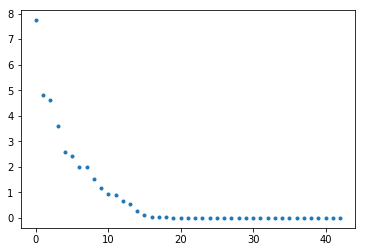

In [78]:
eig_vals_sort = np.sort(eig_vals)[::-1]
# print(eig_vals_sort)

plt.plot(eig_vals_sort, '.')
plt.show()

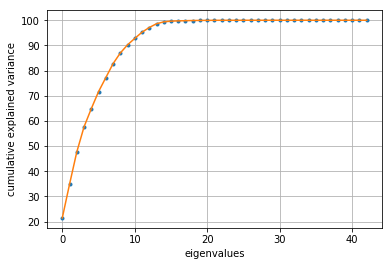

In [85]:
# eig_val_sort_ind = np.argsort(eig_vals)[::-1]

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.plot(cum_var_exp, '.')
plt.plot(cum_var_exp, '-')
plt.xlabel('eigenvalues')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [86]:
print(cum_var_exp)
ind = next(x[0] for x in enumerate(cum_var_exp) if x[1] > 99.0)
print('number of principle component:', ind)

[ 21.49421751  34.87431564  47.67772915  57.65433906  64.86785424
  71.628148    77.18121581  82.71916138  86.97186008  90.22026122
  92.7864301   95.24447476  97.10833751  98.61679802  99.34827892
  99.6392769   99.74860462  99.82737678  99.8937491   99.93440731
  99.9597469   99.98035961  99.9870971   99.99242315  99.99523804
  99.99675009  99.99759997  99.99842404  99.99897612  99.99951773
  99.99982903  99.99999702  99.99999993 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.        ]
number of principle component: 14


In [89]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs2 = [(np.abs(eig_vals2[i]), eig_vecs2[:,i]) for i in range(len(eig_vals2))]
# eig_pairs3 = [(np.abs(eig_vals3[i]), eig_vecs3[:,i]) for i in range(len(eig_vals3))]

# print(eig_pairs)
eig_pairs = sorted(eig_pairs, key=itemgetter(0))
eig_pairs.reverse()
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
matrix_w = np.hstack([eig_pairs[i][1].reshape(43,1) for i in range(ind)])
matrix_w2 = np.hstack([eig_pairs2[i][1].reshape(43,1) for i in range(ind)])
# matrix_w3 = np.hstack([eig_pairs3[i][1].reshape(43,1) for i in range(ind)])

print(np.shape(matrix_w))
# matrix_w

Eigenvalues in descending order:
7.738801626430048
4.817385194256525
4.609755033159869
3.5919895637648844
2.597161909762069
2.433983574615235
1.9993326216547964
1.9938879902389102
1.5311463017596323
1.1695579043426871
0.9239262568053719
0.8849970948216312
0.6710671845219388
0.5431077759521491
0.26336318649213625
0.10477123175400861
0.03936246963205142
0.028361215647843878
0.023896761979948777
0.014638629205447512
0.009123292422997625
0.007421421438165848
0.0024257724691672702
0.0019175982485342786
0.0010134747686110575
0.0005444031335546098
0.0003059902809158761
0.0002966992888568689
0.0001987714593062115
0.00019500032883054165
0.0001120803976669187
6.048508745018919e-05
1.048260884306368e-06
2.3544043722073607e-08
8.648335363154048e-10
2.5010208629567356e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(43, 14)


In [91]:
Y = X_std.dot(matrix_w)
Y2 = X_std2.dot(matrix_w2)
# Y3 = X_std3.dot(matrix_w3)
print(np.shape(Y))

TP = np.matmul(Y, matrix_w.T)
print(np.shape(TP))

residual_pca1 = X_std - TP
residual_pca = np.sqrt(np.square(residual_pca1))
print(np.shape(residual_pca))

(8761, 14)
(8761, 43)
(8761, 43)


In [122]:
pca = PCA(n_components=15)
pca.fit(X_train1)
scores = pca.transform(X_train1)
reconstruct = pca.inverse_transform(scores )
residual_pca1=X_train1-reconstruct
residual_pca1 = np.sqrt(np.square(residual_pca1))
print(np.shape(residual_pca1))
residual_full = np.sum(residual_pca1, axis=1)
print(np.shape(residual_full))


(8761, 43)
(8761,)


(8761,)
(4177, 43)
(8761,)


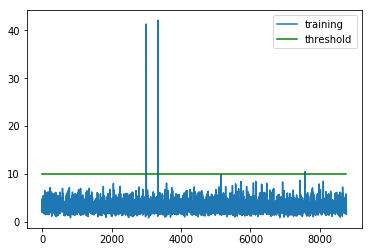

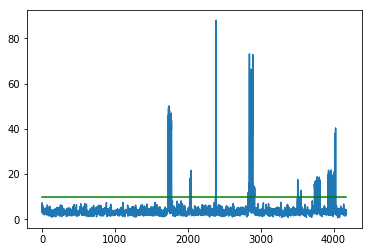

In [139]:
residual_full = np.sum(residual_pca1, axis=1)
print(np.shape(residual_full))
scores2 = pca.transform(X_train2)
# Reconstruct from the 2 dimensional scores 
reconstruct2 = pca.inverse_transform(scores2)

residual_pca2=X_train2-reconstruct2
residual_pca2 = np.sqrt(np.square(residual_pca2))
print(np.shape(residual_pca2))
residual_full2 = np.sum(residual_pca2, axis=1)
print(np.shape(residual_full))


plt.plot(residual_full, label='training')
plt.plot([0,len(residual_full)],[10,10],'g', label='threshold')
# plt.title('Full residual')
plt.legend()
plt.show()

plt.plot(residual_full2, label='val')
plt.plot([0,len(residual_full2)],[10,10],'g')
# plt.title('Full residual')
plt.show()

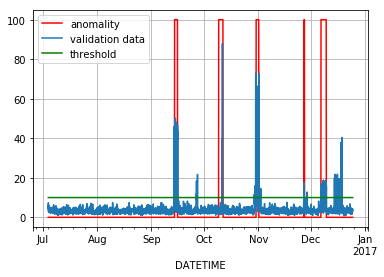

In [138]:
# plot_dataset(X_train2, y_train2)
train2_df['threshold'] = np.ones(len(train2_df))*10
train2_df['ATT_FLAG_anom'] = np.where(train2_df['ATT_FLAG'] == 1, 100, 0)
ax = train2_df['ATT_FLAG_anom'].plot(grid=True, color='r', label='anomality')
train2_df['pca_anom'] = residual_full2
ax2 = train2_df['pca_anom'].plot(grid=True, label='validation data')
ax3 = train2_df['threshold'].plot(grid=True, color='g', label='threshold')
plt.legend(loc=2)
plt.show()

In [125]:
def batadal_metric(train2_df, y_pred):
    counter = 0
    found_c = 0
    bit = 0
    counter_list = []
    for rindex, row in train2_df.iterrows():
        if row['ATT_FLAG'] == 1:
            if bit == 0:
                counter = 0
                bit = 1
                found_c+=1
            counter+=1
        else:
            if bit == 1:
                for c in range(counter):
                    counter_list.append((c+1)/counter)
                bit = 0 
            counter_list.append(0)

    train2_df['TDD'] = counter_list
    train2_df['y_pred'] = y_pred
    
    counter = 0
    found_c = 0
    
    arr = train2_df[['ATT_FLAG', 'TDD']].values
    for i in range(len(arr)):#rindex, row in train2_df.iterrows():
        if arr[i][0] == 1:
            if y_pred[i] == 1 and bit == 0:
#                 print(arr[i][1])
                counter += arr[i][1]
                bit = 1
                found_c+=1
        else:
            bit = 0 
#     print('A')
#     print(counter, found_c)
    S_TDD = 1 - counter/found_c
    return S_TDD


In [126]:
ind = np.argwhere(residual_full2 > 10).reshape(-1)
y_pred = np.where(residual_full2 > 10, 1, 0)
# print(np.count_nonzero(y_pred == 1))
P_am = np.where(y_train2 == 1)
F_am = np.where(y_train2 == -999)

# print(np.shape(F_am))
print(len(ind))

mask_TP = np.isin(ind, P_am)
mask_FP = np.isin(ind, F_am)

TP = len(ind[mask_TP])
FP = len(ind[mask_FP])
TN = np.shape(F_am)[1] - FP

print(TP, FP, TN)

accuracy = (TP+TN)/len(y_train2)
precision = TP/(TP+FP)
print('accuracy: {}, precision: {}'.format(accuracy, precision))
print('batadal: {}'.format(batadal_metric(train2_df, y_pred)))


189
98 90 3868
accuracy: 0.9494852765142446, precision: 0.5212765957446809
batadal: 0.7698339626438524
